# Industry Accelerators - Utilities Customer Attrition Prediction Model


### Contents
- [Introduction](#intro)
- [Functions](#Function)
- [Load Data](#load)
- [User Inputs](#inputs)
- [Data Preparation](#prep)
- [Visualize the data](#visualize)
- [Build Machine Learning Models](#build)
- [Save and Deploy the model](#deploy)

## Introduction <a name="intro"></a>

In this notebook we will go through the end-to-end process of importing raw data, preparing the data, testing machine learning models, selecting the best performing model and deploying a pipeline and scoring to make predictions. The model predicts how likely a customer is to attrit based on customer demographic and Utilities retail details, as well as their historical energy usage. We will use sklearn transformers and a pipeline to complete the steps of transforming the raw data and building a machine learning model, before deploying the pipeline using Watson Machine Learning.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020, 2023. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

In the cell below we import the python libraries that we will use throughout the notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import random
import string

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from tqdm.notebook import tqdm
# use this library for reading and saving data in CP4D
from project_lib import Project
project = Project()

try:
    import lime
except:
    !pip install lime
    import lime
import lime.lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=bf24b60d146f49b3150f8f80bdafb990790f4cb20c1a21de36a321101c28592b
  Stored in directory: /tmp/1000680000/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


## Functions <a name="Function"></a>

The following cell contains a function which generates a number of plots which are used for some preliminary analysis. The first chart shows the distribution of the variable passed to the function. If the variable is numerical, a second plot is generated which shows the variable bucketed up. The last plot shows the percentage of attited cases within each bucket for numerical variables or within each category for categorical variables. This gives the data scientist an idea of what single variables can influence attrition.  

In [2]:
def plot_distribution_and_target_density(df, col_name, chart_type, target_col):
    if chart_type == 'numerical':
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))
        plt.subplots_adjust(hspace = 0.4)
        ax1.set_title('Variable Distribution - ' + col_name)
        dist_plt = sns.histplot(df[col_name], kde=False, ax=ax1)   
        # bin the numerical data
        # if there are less than 10 unique numbers, just split into the number of unique numbers
        if len(df[col_name].unique()) < 10:
            df[col_name + '_BINNED'] = pd.qcut(df[col_name], len(df[col_name].unique())-1)
        else:
            df[col_name + '_BINNED'] = pd.qcut(df[col_name], 10)
        col_name = col_name + '_BINNED'
        

    elif chart_type == 'categorical':
        fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(25, 6))
        plt.subplots_adjust(hspace = 0.4)

    df_var_summary = df.groupby(col_name)[target_col].agg(['count', 'mean']).reset_index()
    df_var_summary.rename(columns={'count':'Number of Records', 'mean':'Target Density'}, inplace=True)
    
    # if we are using a binned variable sort binning lowest to highest
    # we can also drop it from the raw data now
    # if categorical, sort by the number of records
    if chart_type == 'numerical': 
        df_var_summary.sort_values(col_name, inplace=True)
        df.drop(col_name, axis=1, inplace=True)
    elif chart_type == 'categorical':
        df_var_summary.sort_values('Number of Records', inplace=True, ascending=False)

    ax2.set_title('Number of Records per Category - ' + col_name)

    category_plt = sns.barplot(x=col_name,y='Number of Records',data=df_var_summary, color="skyblue", ax=ax2)
    category_plt = category_plt.set_xticklabels(category_plt.get_xticklabels(), rotation=30, horizontalalignment='right')
    category_plt = ax2.set_xlabel('')

    target_density_plot = sns.barplot(x=col_name, y='Target Density', data=df_var_summary, color="skyblue", ax=ax3)

    ax3.set_title('Target Density per Category - ' + col_name)

    for patch in ax3.patches:
        bar_height = patch.get_height()
        ax3.text(patch.get_x()+patch.get_width()/2.,
                bar_height/2,
                np.round(bar_height, 2),
                ha='center', color='white', weight='bold', fontsize=10) 

    target_density_plot.axhline(y=df[target_col].mean(), ls='--')
    target_density_plot.text(1, df[target_col].mean() + 0.01, 'Average Target Density :' + str(np.round(df[target_col].mean(), 2)), fontsize=10, va='center', ha='center')
    target_density_plot = target_density_plot.set_xticklabels(target_density_plot.get_xticklabels(), rotation=30, horizontalalignment='right')
    target_density_plot = ax3.set_xlabel('')
    
    return

In [3]:
def plot_feature_importance(feature_list, feature_importances, title='Feature Importance Plot'):
    """
    Function to Plot Feature Importances
    """
    features = feature_list
    importances = feature_importances
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=16, fontweight='bold')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
  
    return

## Load Customer Attrition Data <a name="load"></a>

We provide a dataset with demographical and behavioural attributes for our customers. Each customer has one record in the dataset and is stamped with whether the customer attrited or not. The Customer data has been amended from that used in the original version of this accelerator.The amended data introduces bias and is used to show the capabilities of Watson OpenScale. The SQL query to create the dataset is included in the project. The cells below import the data using the `project_lib` library and display a sample of the raw data.

In [4]:
my_file = project.get_file('Attrition View.csv')
my_file.seek(0)
df_raw = pd.read_csv(my_file)
df_raw.head()

CUSTOMER_ID  GENDER_ID FIRST_NAME  LAST_NAME       PHONE_1  \
0            1          2     Leonor  Cummerata  781-757-3537   
1            2          1        Ima    Labadie  505-339-5197   
2            3          1     Brycen  Hermiston  309-713-5431   
3            4          2    Nicolas   Baumbach  507-490-8532   
4            5          2    Deshawn       Ryan  409-899-6328   

                           EMAIL  AGE  ENERGY_USAGE_PER_MONTH  \
0      Leonor.Cummerata@nola.biz   44                    5080   
1           Ima.Labadie@allie.tv   34                    4970   
2  Brycen.Hermiston@kristina.biz   39                    9250   
3     Nicolas.Baumbach@amber.biz   37                    4330   
4     Deshawn.Ryan@kristoffer.us   54                    9190   

   ENERGY_EFFICIENCY  IS_REGISTERED_FOR_ALERTS  ...   SEGMENT  \
0              0.390                         1  ...  PLATINUM   
1              0.356                         0  ...      GOLD   
2              0.628                         1  ...      GOLD   
3              0.335                         1  ...    SILVER   
4              0.411                         1  ...       NaN   

           EMPLOYMENT  STD_YRLY_USAGE_CUR_YEAR_MINUS_1  \
0  Employed full-time                            56049   
1  Employed full-time                            52098   
2  Employed full-time                            52098   
3  Employed full-time                            52098   
4  Employed full-time                            48148   

   STD_YRLY_USAGE_CUR_YEAR_MINUS_2  STD_YRLY_USAGE_CUR_YEAR_MINUS_3  \
0                            43703                            26666   
1                            40740                            26666   
2                            40740                            24691   
3                            40740                            24691   
4                            37777                            24691   

   STD_YRLY_USAGE_CUR_YEAR_MINUS_4  STD_YRLY_USAGE_CUR_YEAR_MINUS_5  \
0                            26666                            28642   
1                            26666                            26666   
2                            24691                            26666   
3                            24691                            26666   
4                            24691                            24691   

  STD_YRLY_USAGE_CUR_YEAR_MINUS_6  STD_YRLY_USAGE_CUR_YEAR_MINUS_7  \
0                           26666                            22963   
1                           26666                            21481   
2                           24691                            21481   
3                           24691                            20000   
4                           24691                            20000   

   MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1  
0                               20500  
1                               20500  
2                               20500  
3                               20500  
4                               20500  

[5 rows x 41 columns]

## Specify User Inputs <a name="inputs"></a>

We specify the user inputs in the cell below.

**target_col :** This is the column name for our target variable.<br>
**l_numerical_features :** A list of all of the numerical features that we input into the model. Later in the code, we use a transformer to impute any missing values in these columns. Flag like variables, with values of either 1 or 0 are included in this list.<br>
**l_categorical_for_dummy_vars :** A list of all categorical variables that need to be transformed before input into the model. We will use a transformer to impute missing values and create dummy variables.<br>
**non_feature_cols :** Customer information columns, not used for building the model.


If the data scientist is using their own data, they can easily update the variables below to point at their own specific column names.

In [5]:
target_col = 'ATTRITION_STATUS'

l_numerical_features = ['AGE', 'ENERGY_EFFICIENCY', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_1','STD_YRLY_USAGE_CUR_YEAR_MINUS_2', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_3', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_4','STD_YRLY_USAGE_CUR_YEAR_MINUS_5', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_6', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_7', 'MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1',
                       'IS_REGISTERED_FOR_ALERTS', 'OWNS_HOME', 'COMPLAINTS', 'EBILL', 'IN_WARRANTY', 'ENERGY_USAGE_PER_MONTH', 'TENURE',
                       'HAS_THERMOSTAT', 'HAS_HOME_AUTOMATION', 'PV_ZONING', 'WIND_ZONING', 'IS_CAR_OWNER', 'HAS_EV', 'HAS_PV', 'HAS_WIND']

l_categorical_for_dummy_vars = ['GENDER_ID','SMART_METER_COMMENTS', 'MARITAL_STATUS', 'EDUCATION', 'EMPLOYMENT', 'CITY', 'CURRENT_OFFER', 'CURRENT_CONTRACT', 'CURRENT_ISSUE', 'SEGMENT']

non_feature_cols=['CUSTOMER_ID','FIRST_NAME', 'LAST_NAME', 'PHONE_1','EMAIL']


### Display Target Distribution

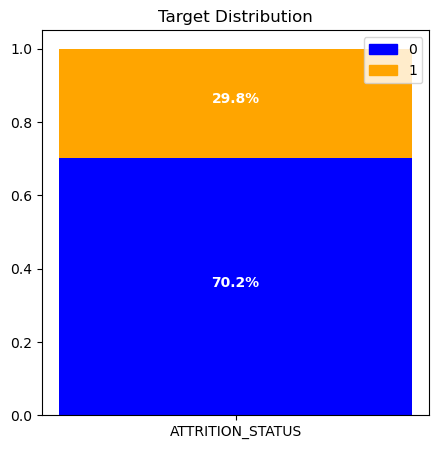

In [6]:
# start by having a look at the target variable
df_temp = df_raw[target_col].value_counts().reset_index()
df_temp['perc'] = df_temp[target_col] / df_temp[target_col].sum()

target_0 = df_temp[df_temp['index']==0]['perc'].values[0]
target_1 = df_temp[df_temp['index']==1]['perc'].values[0]

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.bar(target_col, target_0, label=target_0, color='blue')
ax1.bar(target_col, target_1, bottom=target_0, color='orange')

red_patch = mpatches.Patch(color='orange', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')

plt.legend(handles=[blue_patch, red_patch], loc='best')

plt.title('Target Distribution')

for patch in ax1.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height())
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_y() + patch.get_height()/2
    ax1.annotate(percentage, (x, y), ha='center', color='white', weight='bold', fontsize=10)


## Data Prep <a name="prep"></a>



### Correlation Analysis

We carry out a correlation analysis on all variables specified in `l_numerical_features`.

From the result of the analysis we can see that the historical yearly usage is very highly correlated. This is most likely due to the nature of how this synthetic data was generated. We remove all but 1 of these variables from the numerical list. While they remain in our dataset they will be dropped from the transformer and not used as input into the model.

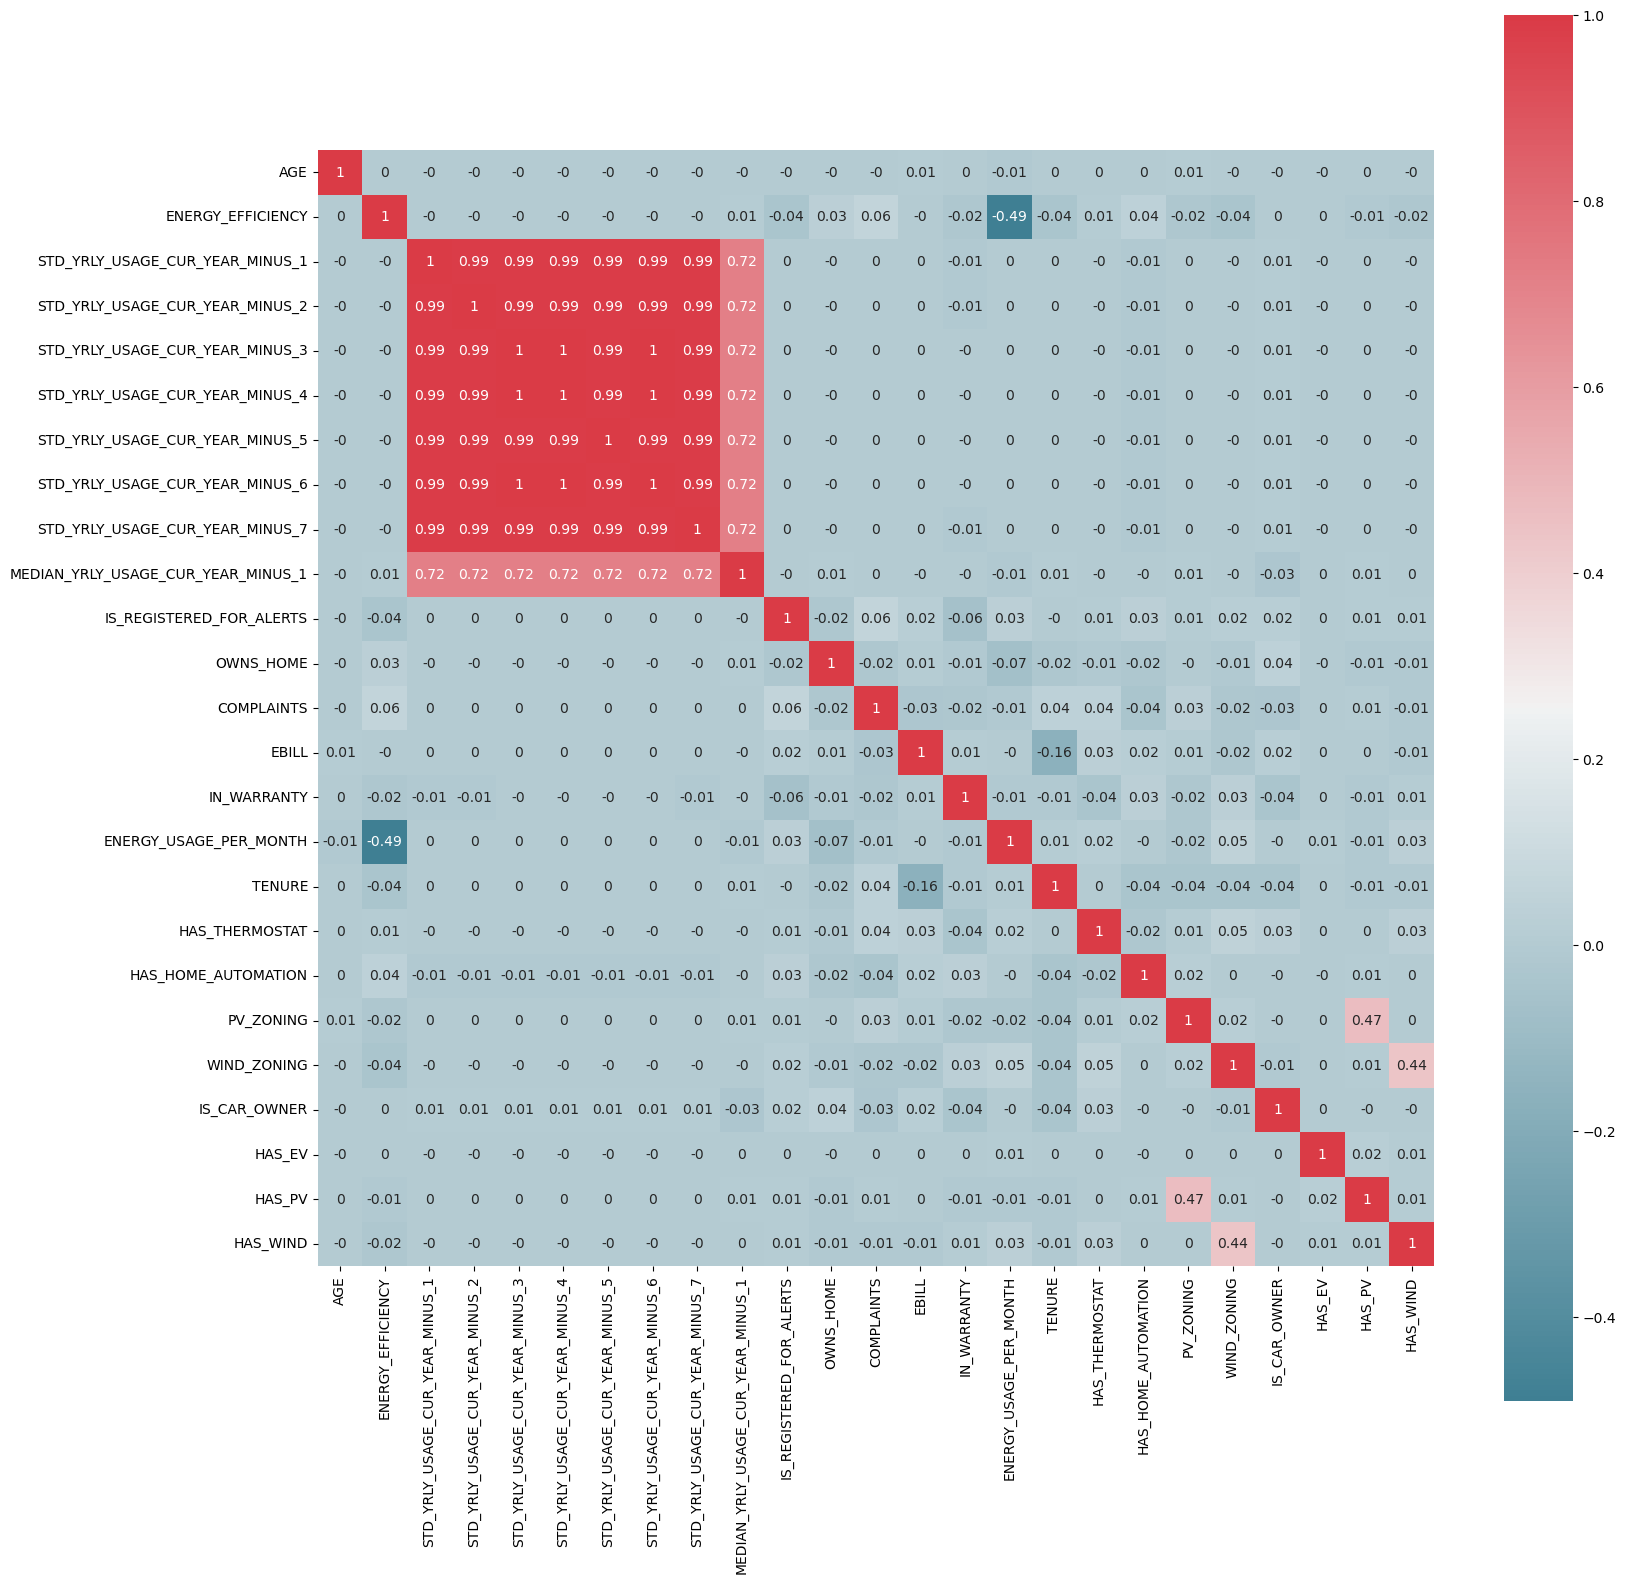

In [7]:
# Copy the raw data into a dataframe
df_prep=df_raw.copy()
# check correlation between numerical features
f, ax = plt.subplots(figsize=(18, 18))
corr = df_prep[l_numerical_features].corr()
corr = corr.round(2)
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

In [8]:
# the annual usage over the last 7 years is highly correlated - a result of the how the synthetic data was generated 
# we can remove all but 1 of these variables
l_numerical_cols_to_drop = ['STD_YRLY_USAGE_CUR_YEAR_MINUS_2', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_3', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_4','STD_YRLY_USAGE_CUR_YEAR_MINUS_5', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_6', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_7']

# also remove them from the list of numerical features
l_numerical_features = [i for i in l_numerical_features if i not in l_numerical_cols_to_drop]

df_prep=df_prep.drop(columns=l_numerical_cols_to_drop,axis=1)
# Also remove the columns that are not used in the modelling 
df_prep=df_prep.drop(columns=non_feature_cols,axis=1)
df_prep.head()

GENDER_ID  AGE  ENERGY_USAGE_PER_MONTH  ENERGY_EFFICIENCY  \
0          2   44                    5080              0.390   
1          1   34                    4970              0.356   
2          1   39                    9250              0.628   
3          2   37                    4330              0.335   
4          2   54                    9190              0.411   

   IS_REGISTERED_FOR_ALERTS  OWNS_HOME  COMPLAINTS  ATTRITION_STATUS  \
0                         1          1           0                 0   
1                         0          1           1                 1   
2                         1          1           0                 0   
3                         1          1           0                 1   
4                         1          1           1                 0   

   HAS_THERMOSTAT  HAS_HOME_AUTOMATION  ...           CITY  \
0               1                    0  ...  Mountain View   
1               1                    0  ...  Mountain View   
2               1                    1  ...      Sunnyvale   
3               0                    0  ...    Santa Clara   
4               0                    1  ...    Santa Clara   

        CURRENT_OFFER                 CURRENT_CONTRACT      CURRENT_ISSUE  \
0  Home Energy Audits                      Time of Use  Replacement phone   
1  Free Energy Audits  Dynamic Pricing 240 minute plan      Billing Issue   
2  Home Energy Audits                      Time of Use      Billing Issue   
3       Rooftop Solar                      Time of Use      Billing Issue   
4       Rooftop Solar                              NaN         Drop Calls   

   MARITAL_STATUS                  EDUCATION   SEGMENT          EMPLOYMENT  \
0               S           Associate degree  PLATINUM  Employed full-time   
1               U          Bachelor's degree      GOLD  Employed full-time   
2               U  Bachelor's degree or more      GOLD  Employed full-time   
3               M  Bachelor's degree or more    SILVER  Employed full-time   
4               U  Bachelor's degree or more       NaN  Employed full-time   

   STD_YRLY_USAGE_CUR_YEAR_MINUS_1  MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1  
0                            56049                               20500  
1                            52098                               20500  
2                            52098                               20500  
3                            52098                               20500  
4                            48148                               20500  

[5 rows x 30 columns]

## Visualise the Input Data <a name="visualize"></a>

As already described, we use the `plot_distribution_and_target_density`function to create plots for a selection of variables. The user specifies the column to be visualised and whether the column is numerical or categorical.

For numerical variables, 3 charts are displayed:
  1. Distribution of the numerical variable.
  2. Group the numerical data into 10 buckets of equal size. Display the number of cases in each bucket and the range of values in each.
  3. Display the percentage of cases in each bucket that have attrited. 

The charts for categorical variables are very similar, but we don't need to bucket categorical variables. 2 charts are displayed:
  1. Distribution of the categorical variable. Displays the number of cases in each category of the variable.
  2. Display the percentage of cases in each category that have attrited. 

We first plot **Energy Efficiency**. The values for efficiency range from 0.3 to 0.83, with a slight skew, more customers have lower energy efficiency. Looking at the target density after bucketing the variable, we see little variation in target density for the first 5 buckets. The target density is very close to average in these buckets. We see a higher target density in the bucket containing 0.5 efficiency and much lower in the 8th bucket.  

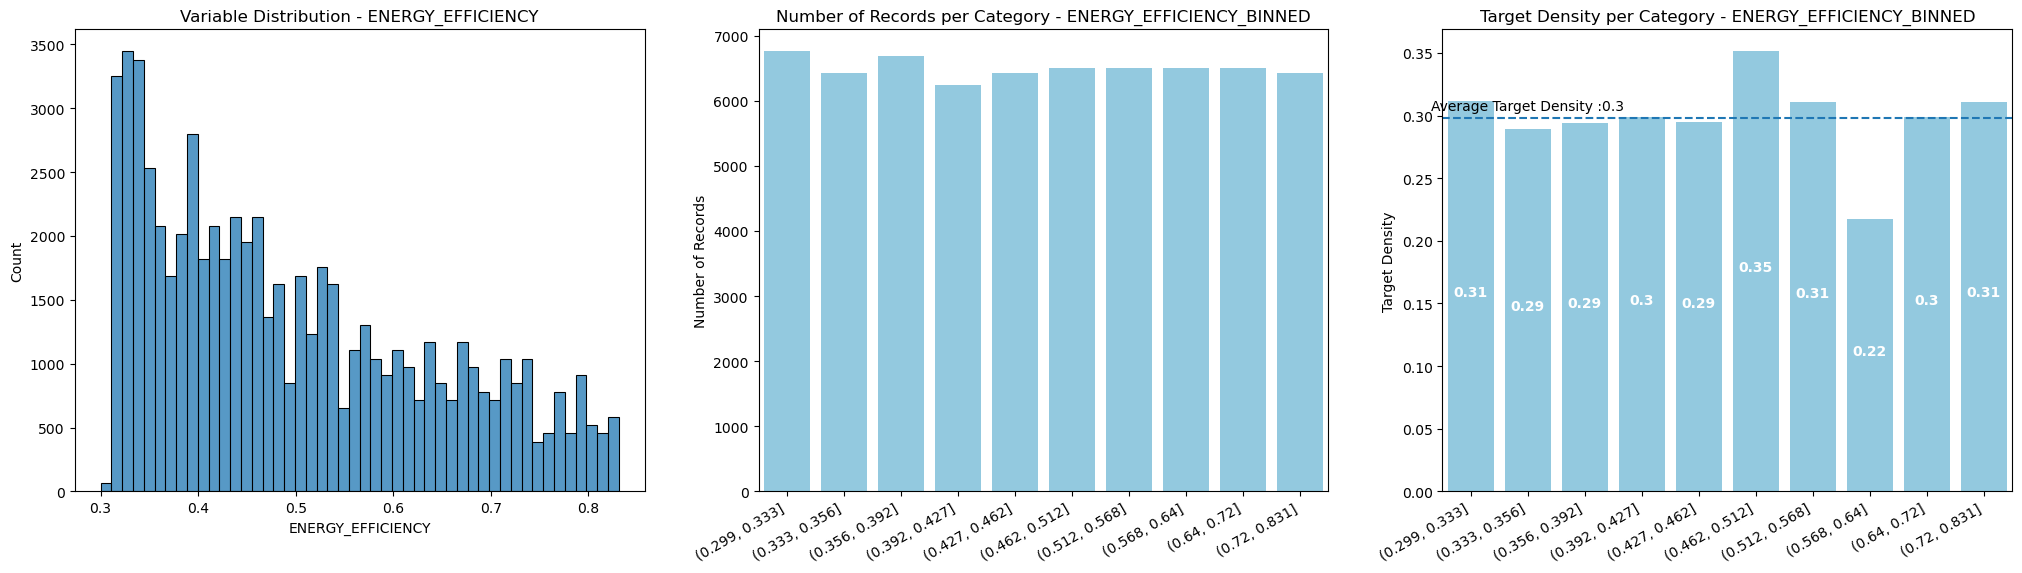

In [9]:
chart_type = 'numerical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'ENERGY_EFFICIENCY', chart_type, target_col)

Next we look at **Tenure**. The values range between 1 and 72. We see that there is a higher percentage of attrition cases in buckets 2 and 6. These buckets contain 12 and 36 months respectively. Could these indicate some contract lengths and we see customers leaving after their contract expires?

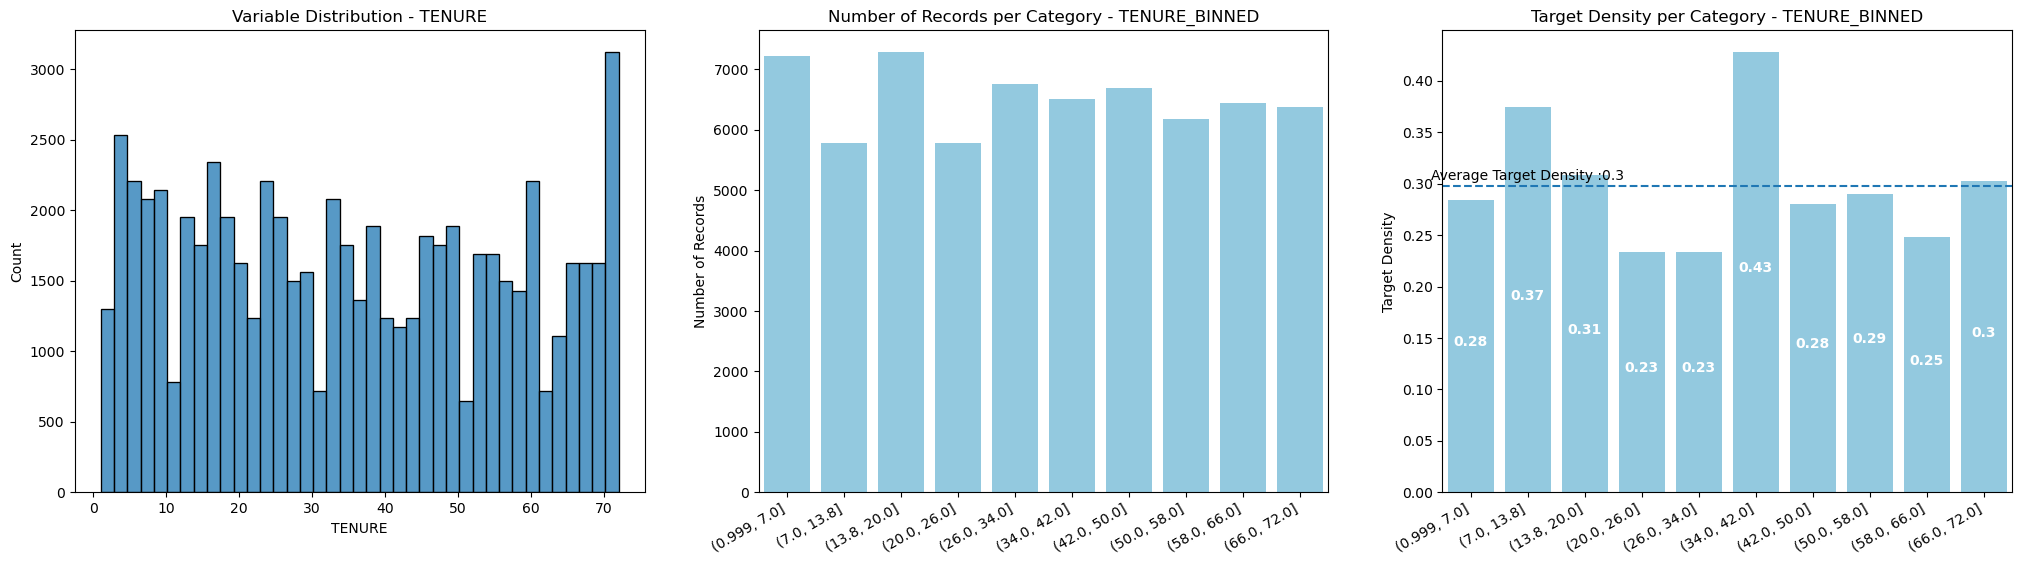

In [10]:
chart_type = 'numerical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'TENURE', chart_type, target_col)

As a final example for the numerical variables, we look at **Age**. This is an example of a variable that gives limited insight by itself. There is very little variation across buckets, with all target density's being very similar to the average. 

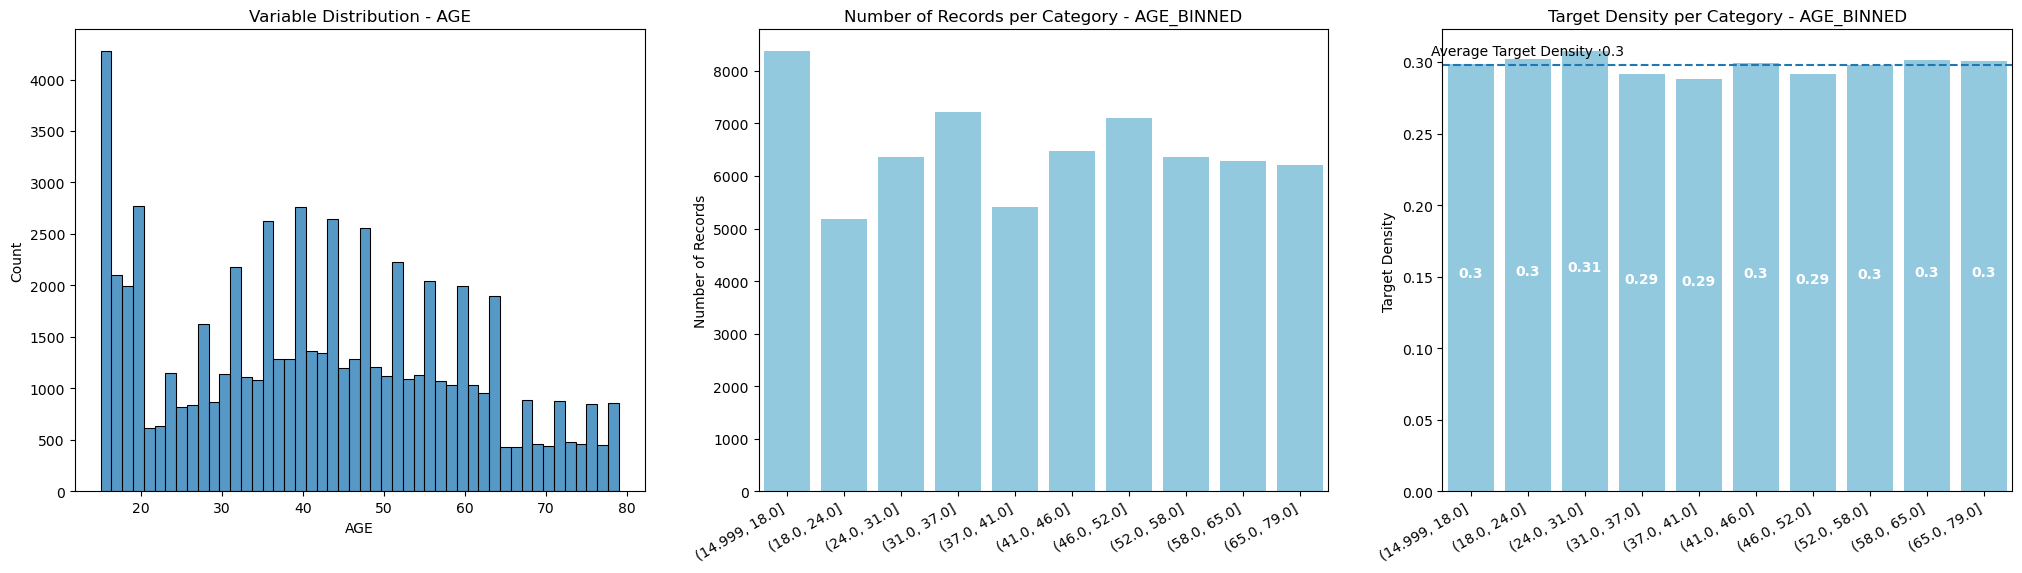

In [11]:
chart_type = 'numerical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'AGE', chart_type, target_col)

Next we look at **Complaints**. The majority of customers have not previously made a complaint, but for those who have, a higher percentage of them have attrited.

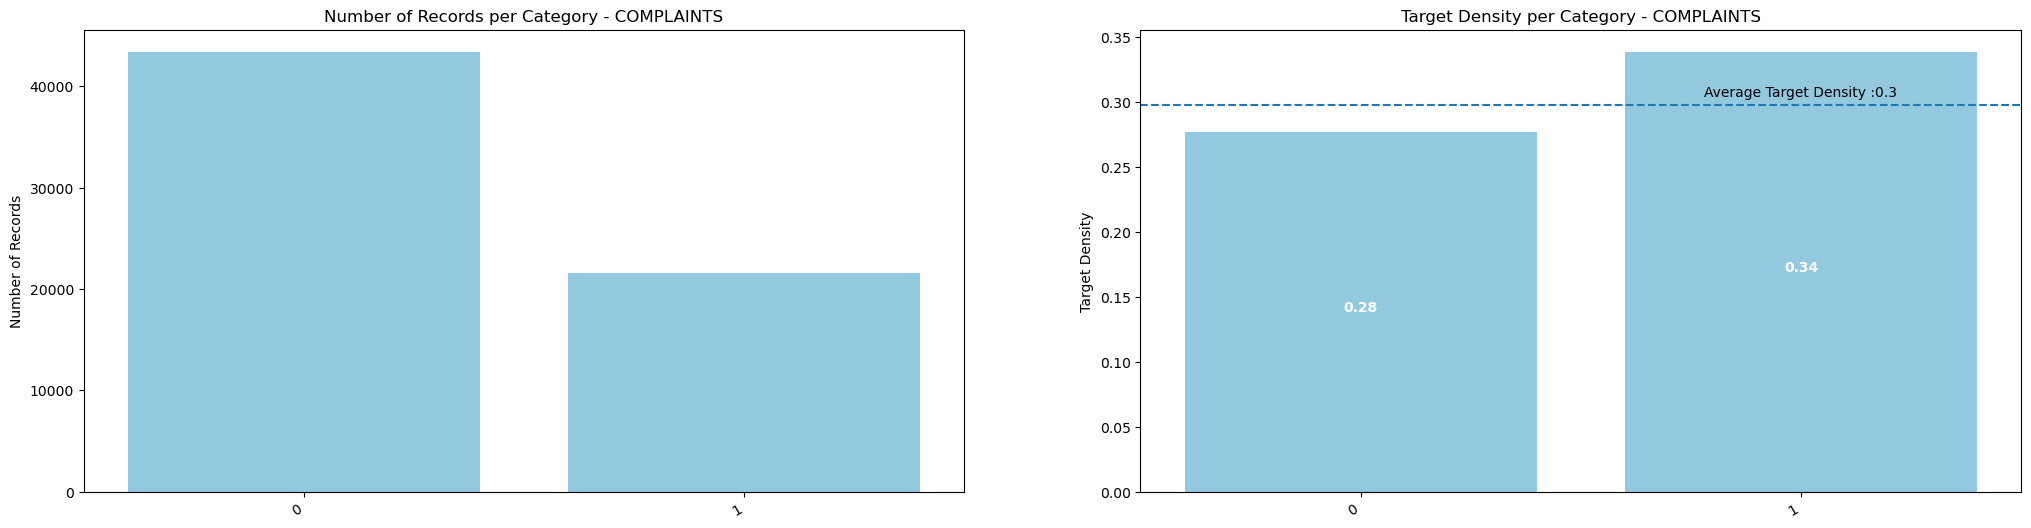

In [12]:
chart_type = 'categorical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'COMPLAINTS', chart_type, target_col)

We have 6 categories in the **Employment** variable. The majority of customers are employed full-time. These customers as well as Students have a higher than average percentage of attrition cases.

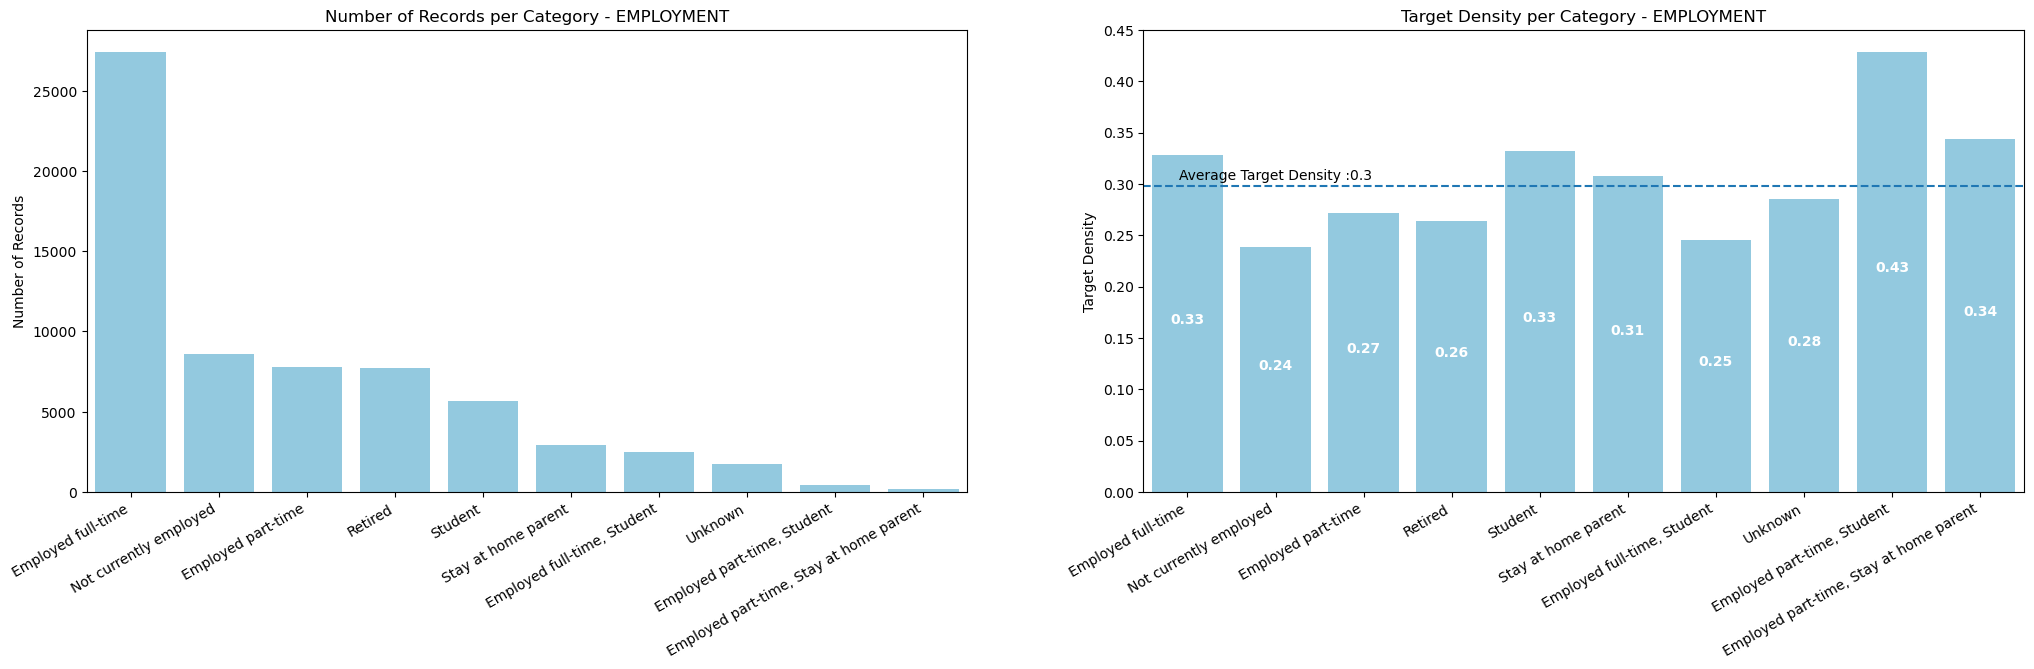

In [13]:
chart_type = 'categorical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'EMPLOYMENT', chart_type, target_col)

Finally, for **HAS_EV** variable indicates whether a customer owns an electric vehicle or not. The majority of customers do not own an EV. Of those customers who do, they are much less likely to attrit. 

In [14]:
chart_type = 'categorical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'HAS_EV', chart_type, target_col)

## Build Machine Learning Models <a name="build"></a>

### Split Data and Build Transformer

We split the data into training, validation and test sets. We use 60% of the data for training, 20% for validation and the remaining 20% for testing. We build the models on the training set, carry out hyperparameter tuning on the validation set and finally apply the selected model to the unseen test set.  

We use built-in sklearn transformers to process the data and get it ready for input into the model. 

For categorical variables we create a pipeline with 2 steps. We first use the `SimpleImputer`transformer to fill in missing values with 'Other'. Next we use `OneHotEncoder` to create dummy variables for each category. The transformers are applied to the features specified in the `l_categorical_for_dummy_vars`variable.

For numerical variables the pipeline has a single step in our example. We again use the `SimpleImputer`transformer to fill in missing values. The transformer is applied to the features specified in `l_numerical_features`variable.  

The transformers are combined, and to test it out, we fit and transform them to the training data. We then transform the test data.  

In [15]:
X = df_prep.drop([target_col], axis=1)
y = df_prep[target_col]

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, stratify=y, test_size=0.40, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_val_test, y_val_test, stratify=y_val_test, test_size=0.50, random_state=0)

In [16]:
X_test.head()

GENDER_ID  AGE  ENERGY_USAGE_PER_MONTH  ENERGY_EFFICIENCY  \
53000          2   19                    5080              0.390   
15930          2   58                    8800              0.334   
56821          2   52                    5920              0.787   
21164          2   66                    9670              0.385   
6457           2   38                    3330              0.571   

       IS_REGISTERED_FOR_ALERTS  OWNS_HOME  COMPLAINTS  HAS_THERMOSTAT  \
53000                         1          1           0               1   
15930                         0          1           1               1   
56821                         0          1           0               1   
21164                         1          1           0               1   
6457                          1          1           1               1   

       HAS_HOME_AUTOMATION  PV_ZONING  ...           CITY       CURRENT_OFFER  \
53000                    0          1  ...  Mountain View  Home Energy Audits   
15930                    0          1  ...    Santa Clara       Rooftop Solar   
56821                    1          0  ...      Sunnyvale       Rooftop Solar   
21164                    0          0  ...      Sunnyvale  Home Energy Audits   
6457                     0          0  ...      Palo Alto       Rooftop Solar   

       CURRENT_CONTRACT        CURRENT_ISSUE  MARITAL_STATUS  \
53000       Time of Use    Replacement phone               S   
15930       Time of Use  Best friend cancels               M   
56821       Time of Use  Best friend cancels               M   
21164               NaN           Drop Calls               M   
6457                NaN           Drop Calls               S   

               EDUCATION   SEGMENT              EMPLOYMENT  \
53000   Associate degree  PLATINUM      Employed full-time   
15930    Master's degree      GOLD      Employed part-time   
56821   Associate degree      GOLD  Not currently employed   
21164  Bachelor's degree       NaN                 Student   
6457    Associate degree       NaN  Not currently employed   

       STD_YRLY_USAGE_CUR_YEAR_MINUS_1 MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1  
53000                              740                               3210  
15930                            44197                              20500  
56821                            19012                              26900  
21164                            24444                              20500  
6457                             16543                              20500  

[5 rows x 29 columns]

In [17]:
categorical_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='Other')), ('dummy_vars', OneHotEncoder(handle_unknown='ignore'))])

In [18]:
# we don't have any missing data in our dataset but we keep this here for demonstration purposes and as data for scoring may have missing data
numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median'))])

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, l_numerical_features),
        ('cat', categorical_transformer, l_categorical_for_dummy_vars)
            ])

In [20]:
X_train_postprocess = preprocessor.fit_transform(X_train)
fitted_preprocessor = preprocessor.fit(X_train)
X_validation_postprocess = preprocessor.transform(X_validation)
X_test_postprocess = preprocessor.transform(X_test)

X_total_postprocess = preprocessor.transform(X)


In [21]:

onehot_columns=list(preprocessor.named_transformers_['cat'].named_steps['dummy_vars'].get_feature_names_out(input_features=l_categorical_for_dummy_vars))
numeric_features_list = list(l_numerical_features)
numeric_features_list.extend(onehot_columns)

### Model Hyperparameter Tuning and Model Selection

We selected a random forest model for this example. We do some hyperparameter tuning and select the final hyperparameters based on the best AUC on the validation set. 

In [22]:
l_ne = [50,60]
l_md = [9,11] 
l_mf = [0.5,0.6]

highest_validation_auc = 0.0
top_ne = 0
top_md = 0
top_mf = 0.0

for ne in l_ne:
    for md in l_md:
        for mf in l_mf:
            clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, random_state=0)
            clf.fit(X_train_postprocess, y_train)
            
            y_pred_train = clf.predict_proba(X_train_postprocess)[:,1]
            y_pred_validation = clf.predict_proba(X_validation_postprocess)[:,1]
            
            fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
            fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)

            auc_validation = metrics.auc(fpr_validation, tpr_validation)
            auc_train = metrics.auc(fpr_train, tpr_train)

            if auc_validation > highest_validation_auc:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features***')
                top_ne = ne
                top_md = md
                top_mf = mf
                highest_validation_auc = auc_validation
            else:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features')

Training AUC : 0.903, Validation AUC :0.888 from 50 estimators, 9 max depth and 0.5 max features***
Training AUC : 0.906, Validation AUC :0.888 from 50 estimators, 9 max depth and 0.6 max features***
Training AUC : 0.957, Validation AUC :0.929 from 50 estimators, 11 max depth and 0.5 max features***
Training AUC : 0.956, Validation AUC :0.926 from 50 estimators, 11 max depth and 0.6 max features
Training AUC : 0.905, Validation AUC :0.889 from 60 estimators, 9 max depth and 0.5 max features
Training AUC : 0.908, Validation AUC :0.892 from 60 estimators, 9 max depth and 0.6 max features
Training AUC : 0.958, Validation AUC :0.929 from 60 estimators, 11 max depth and 0.5 max features***
Training AUC : 0.957, Validation AUC :0.927 from 60 estimators, 11 max depth and 0.6 max features


### Build Final Model and Pipeline

Next we create a pipeline which combines the preprocessing steps of prepping the data and building the model with the selected hyperparameters. 

With this pipeline we can pass data in in it's raw form, with missing values and categorical data. The missing data is replaced and dummy variables are created, this prepped data is then passed to the model and the model results are returned.

In [23]:
# create the finalised pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=top_ne, max_depth=top_md, max_features=top_mf, random_state=0))])

clf = pipeline.fit(X_train, y_train)
y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_train_class= clf.predict(X_train)
clf.predict_proba(X_validation)
y_pred_validation = clf.predict_proba(X_validation)[:,1]
y_pred_validation_class= clf.predict(X_validation)
clf.predict_proba(X_test)
y_pred_test = clf.predict_proba(X_test)[:,1]
y_pred_test_class= clf.predict(X_test)

fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

auc_train = metrics.auc(fpr_train, tpr_train)
auc_validation = metrics.auc(fpr_validation, tpr_validation)
auc_test = metrics.auc(fpr_test, tpr_test)

print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' and Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(top_ne) + ' estimators, ' + str(top_md) + ' max depth and ' + str(top_mf) + ' max features')

Training AUC : 0.958, Validation AUC :0.929 and Test AUC :0.922 from 60 estimators, 11 max depth and 0.5 max features


### View Model Results

First we'll look at the plot of the ROC curve and use the area under the ROC curve (AUC) as the model evaluation metric. The ROC curve is a plot of the true positive rate `(Sensitivity)` and false positive rate `(1-Specificity)`. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

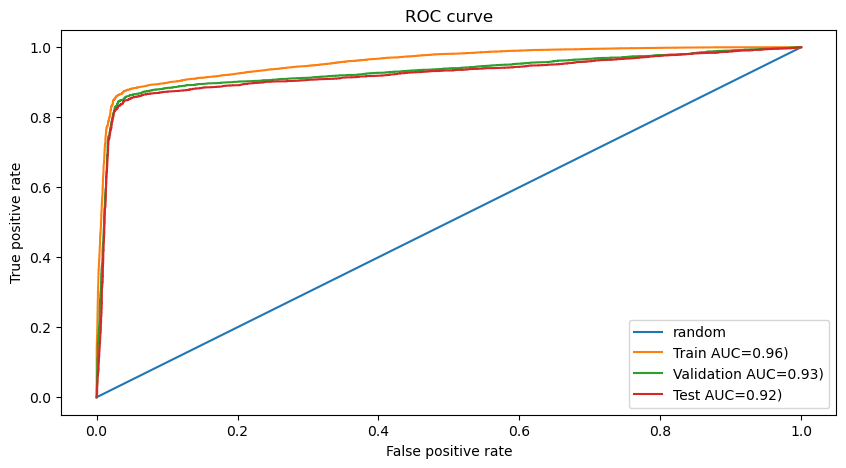

In [24]:
fig = plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], label='random')

plt.plot(fpr_train, tpr_train, label= 'Train AUC=' + str(np.round(auc_train, 2)) + ')')
plt.plot(fpr_validation, tpr_validation, label= 'Validation AUC=' + str(np.round(auc_validation, 2)) + ')')
plt.plot(fpr_test, tpr_test, label= 'Test AUC=' + str(np.round(auc_test, 2)) + ')')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

Based on the validation ROC curve result we select the optimum threshold value based on Youden's Index. Any probabilities greater than the selected threshold will be classed as 1, otherwise 0. 

In [25]:
# get the optimal threshold based on Youden's index
idx_opt_thres = np.argmax(tpr_validation - fpr_validation)
opt_threshold = thresholds_validation[idx_opt_thres]

print(opt_threshold)

y_pred_class_train = y_pred_train 
y_pred_class_train = y_pred_class_train.round().astype(int)
y_pred_class_validation = y_pred_validation 
y_pred_class_validation = y_pred_class_validation.round().astype(int)
y_pred_class_test = y_pred_test 
y_pred_class_test = y_pred_class_test.round().astype(int)

0.34051235059486423


We'll next look at the confusion matrix from the test set results at the selected threshold to summarise the performance of the model and see what types of errors are being made. We can see that, at the selected optimal threshold, the classifier does a good job of correctly classifying customers as attrited or not.  

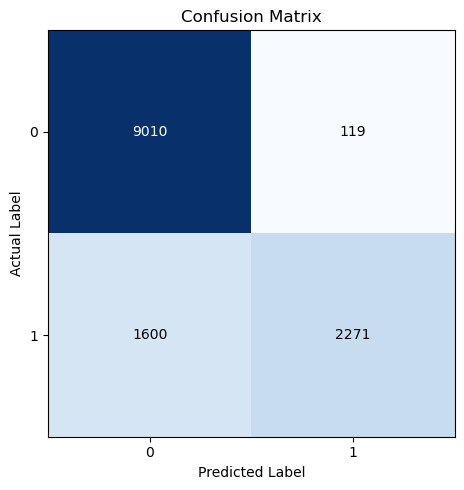

In [26]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test_class, labels=[0,1])

fig  = plt.figure(figsize=(10,5))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0, 1])
plt.yticks(tick_marks, [0, 1])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    plt.text(x, y, num_occurances, color="white" if confusion_matrix[x, y] > confusion_matrix.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

### Cumulative Gains and Lift Charts

Next we generate the cumulative gains chart generated from the data used for model training.

The cumulative gains chart shows the percentage of attrited customers selected by targeting a specific percentage of total customers. The x-axis has the percentage of total customers used in model training and the y-axis has the percentage of customers who actually attrited. Taking an example of targeting the first 10% of customers. If we were to select these customers randomly, we would expect the group to contain 10% of attrited customers, shown by the dotted line in blue in the chart. Based on the model result, targeting this 10% of customers results in a group with 32% of attrited customers.  

The lift chart is derived from the cumulative gains chart. It shows the ratio of the cumulative gain from the model vs random choice. Taking the same example as above and selecting 10% of customers. With random choice we get 10% of attrited customers while we get 32% using the model. The lift is 32%/10% or 3.2.

In [27]:

df_act_vs_pred = X_train.copy()
df_act_vs_pred['actual'] = y_train
df_act_vs_pred['predicted_probability'] = y_pred_train
df_act_vs_pred['predicted_class'] = y_pred_class_train
df_act_vs_pred['dataset'] = 'Seen'

df_temp_validation = X_validation.copy()
df_temp_validation['actual'] = np.nan
df_temp_validation['predicted_probability'] = y_pred_validation
df_temp_validation['predicted_class'] = y_pred_class_validation
df_temp_validation['dataset'] = 'Unseen'
df_temp_test = X_test.copy()
df_temp_test['actual'] = np.nan
df_temp_test['predicted_probability'] = y_pred_test
df_temp_test['predicted_class'] = y_pred_class_test
df_temp_test['dataset'] = 'Unseen'

df_act_vs_pred = pd.concat([df_act_vs_pred,df_temp_validation, df_temp_test],ignore_index=True)

df_act_vs_pred.sort_values(['dataset', 'predicted_probability'], inplace=True, ascending=[True, False])
df_act_vs_pred[l_categorical_for_dummy_vars] = df_act_vs_pred[l_categorical_for_dummy_vars].fillna('Other')
# save the data using the project_lib library

df_temp = df_act_vs_pred[df_act_vs_pred['dataset']=='Seen'].copy()

df_temp['temp'] = range(1, df_temp.shape[0]+1)
df_temp['Bin'] = pd.qcut(df_temp['temp'], 20, labels=False)
df_temp.drop('temp', axis=1, inplace=True)

df_lift_gains_summary = df_temp.groupby('Bin')['actual'].agg(['count', 'sum']).reset_index()
df_lift_gains_summary.rename(columns={'count' : 'Number of Customers', 'sum' : 'Number of Attrited Customers'}, inplace=True)
df_lift_gains_summary['Cumulative % of Customers'] = df_lift_gains_summary['Number of Customers'].cumsum()/df_lift_gains_summary['Number of Customers'].sum()
df_lift_gains_summary['Cumulative % of Attrited Customers'] = df_lift_gains_summary['Number of Attrited Customers'].cumsum()/df_lift_gains_summary['Number of Attrited Customers'].sum()
df_lift_gains_summary['Lift'] = df_lift_gains_summary['Cumulative % of Attrited Customers'] / df_lift_gains_summary['Cumulative % of Customers']

df_act_vs_pred[["CUSTOMER_ID","FIRST_NAME","LAST_NAME","PHONE_1","EMAIL"]]=df_raw[["CUSTOMER_ID","FIRST_NAME","LAST_NAME","PHONE_1","EMAIL"]]
project.save_data('model-output-summary.csv', df_act_vs_pred.to_csv(index=False), overwrite=True)


{'file_name': 'model-output-summary.csv',
 'message': 'File saved to project storage.',
 'asset_id': '9923f801-ca13-4e3a-8d39-b03cb97c1f5d'}

In [28]:
# show a cumulative gains chart
fig = plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], label='random', linestyle='--', linewidth=1)


# we add an element to the start of each series for 0%
plt.plot(pd.concat([pd.Series([0]), df_lift_gains_summary['Cumulative % of Customers']]), pd.concat([pd.Series([0]), df_lift_gains_summary['Cumulative % of Attrited Customers']]), label='model', linewidth=2)

plt.xlabel('Cumulative % of Customers')
plt.ylabel('Cumulative % of Attrited Customers')
plt.title('Cumulative Gains Chart')
plt.legend(loc='best')
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid()

In [29]:
# show the lift chart
fig = plt.figure(figsize=(10,5))
plt.plot([0.05, 1], [1, 1], label='baseline', linestyle='--', linewidth=2)

plt.plot(df_lift_gains_summary['Cumulative % of Customers'], df_lift_gains_summary['Lift'], label='model', linewidth=2)

plt.xlabel('Cumulative % of Customers')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend(loc='best')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.ylim(bottom=0)
plt.grid()

## Feature Importance of the model
With tree based models we can view variable importance plots. These plots indicate, at the feature level, some importance for the variable in classifying the outcome variable. It uses gini importance (mean decrease in impurity) which looks at node impurity. Node impurity is just looking at how well a tree splits the data. Technically it calculates each feature importance as the sum over the number of splits that include the feature, proportionally to the number of samples it splits.

We'll take a look at the feature importance plots for the random forest models. 

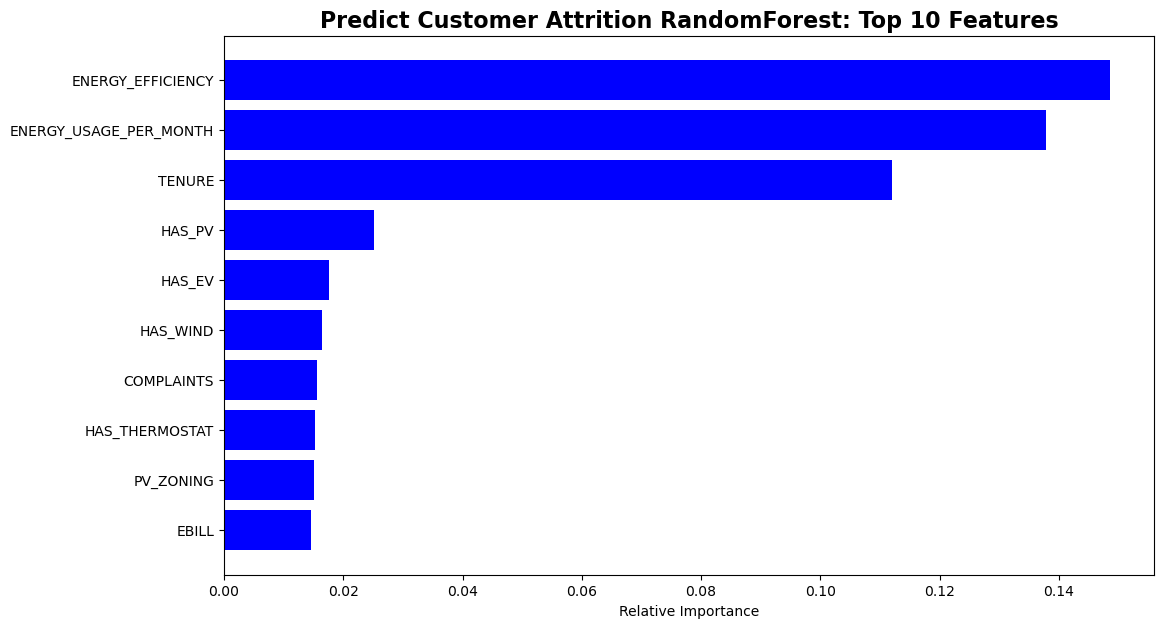

In [30]:
plot_feature_importance(feature_list=numeric_features_list, 
                        feature_importances=pipeline.named_steps['classifier'].feature_importances_, 
                        title="Predict Customer Attrition RandomForest: Top 10 Features")

### Explanation for individual Customer outcomes
We use `lime` based explainer to explain the attrition prediction for any customer. Below cell shows an explanation of all the features impacting the attrition risk for a customer with specified customer number.

In [31]:
# Select a customer for explanation 
customer_id=20
df_explain=df_raw[df_raw.CUSTOMER_ID==customer_id][l_numerical_features+l_categorical_for_dummy_vars].copy()
# transform patients data using fitted preprocessor
explain_postprocess=fitted_preprocessor.transform(df_explain)



In [32]:
# use LimeTabularExplainer to train explainer 
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_postprocess,feature_names = numeric_features_list,class_names=['Not-Attrited','Attrited'],kernel_width=5,mode="classification")
def model_prediction(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray.tolist(),columns=numeric_features_list)
    return pipeline.named_steps['classifier'].predict_proba(data_asframe.to_numpy())

# Pass single patient record to get explanation
exp = explainer.explain_instance(
    data_row=explain_postprocess[0], 
    predict_fn=model_prediction
)

exp.show_in_notebook(show_table=True)

Above chart shows the variables in the right push the outcome towards `Attrition` whereas the variable in the left push the outcome towards `Not-Attrited`. It can also be plotted as below.

Text(0.5, 1.0, 'Effect on Attrition Prediction')

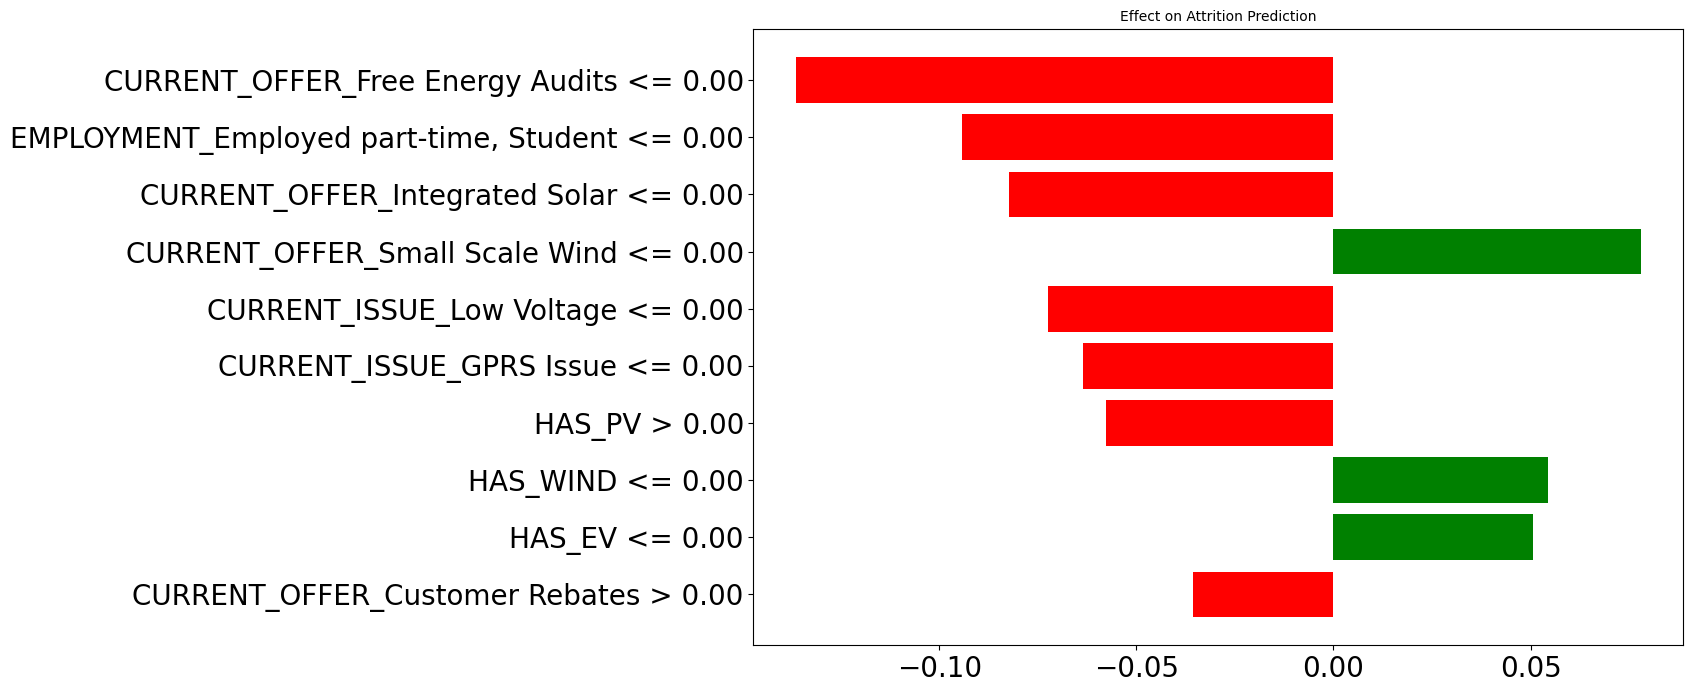

In [33]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
# Plot the prediction explaination
figsize(12, 8)
plt.rcParams['font.size'] = 20
exp.as_pyplot_figure()
plt.title('Effect on Attrition Prediction', size = 10)


In [34]:

num_pat_explain=50
explain_list=[]
for i in tqdm(range(num_pat_explain)):
    exp = explainer.explain_instance(
        data_row=X_total_postprocess[i], 
        predict_fn=model_prediction
    )
    explain_list.append(exp.as_list())

  0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
limeresults=df_raw[['CUSTOMER_ID']].head(50).copy()
limeresults['LIME_Features']=explain_list

project.save_data('explanation-results.csv', limeresults.to_csv(index=False), overwrite=True)

{'file_name': 'explanation-results.csv',
 'message': 'File saved to project storage.',
 'asset_id': 'ed9cef17-40d2-44e1-b668-d097cf7618d7'}

### User Inputs

The user can specify the name for the space, models and model deployments.  <br> Model and its deployment will be stored in the deployment space. The deployment space can be created programmatically using `ibm-watson-machine-learning` client. <br>
If a space with specified space_name already exists, user can either use the existing space by specifying `use_existing_space=True` or delete the existing space and create a new one by specifying `use_existing_space=False` below. By default `use_existing_space` is set to `True`.

## Save the Pipeline to Cloud Pak for Data <a name="deploy"></a>

In the next steps we save and deploy the pipeline. The pipeline can be saved and deployed in the same way we save and deploy models. 

Before we save the pipeline we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space. 

The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these stepss. 

In [36]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'Utilities Customer Attrition Space'
model_name = 'Utilities Customer Attrition Model'
deployment_name = 'Utilities Customer Attrition Model Deployment'


use_existing_space=True

Below code imports ` ibm-watson-machine-learning` library and then creates a wml client using the credentials provided.

In [37]:
from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "4.6"
}

client = APIClient(wml_credentials)

### Create the Deployment Space

Create a new deployment space using name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space. 

By default, if the space with specified name already exists, the existing space will be used to store and deploy the models.

In [38]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with ",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(5)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name

        }

    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)


Creating a new deployment space - Utilities Customer Attrition Space
Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If it's not 'active', you can monitor the state with a call to spaces.get_details(space_id). Alternatively, use background_mode=False when calling client.spaces.store().


### Store the Pipeline Details
Store the pipeline in the deployment space. Again, the name for the pipeline is specified in the user inputs cell above.  Software specification, default tag and input data schema for the model are specified in the model metadata. Example to create a metatadata can be viewed using `client.repository.ModelMetaNames.get_example_values()`. <br>
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `runtime-22.2-py3.10` to store the models. We get the ID of the software specification and include it in the metadata when storing the model.  Available Software specifications can be retrieved using `client.software_specifications.list()`. 

In [39]:
sw_spec_uid = client.software_specifications.get_uid_by_name("runtime-22.2-py3.10")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid,
    client.repository.ModelMetaNames.DESCRIPTION: "Utilities Customer Attrition Model to predict customer attrition based on customer demographic and utilities retail details, as well as their historical energy usage.",
    client.repository.ModelMetaNames.TAGS: ['utilities_attrition_pipeline_tag'],
    client.repository.ModelMetaNames.INPUT_DATA_SCHEMA:[{'id': '1', 'type': 'struct', 'fields': [{"name":column_name,"type":str(column_type[0])} for column_name,column_type in pd.DataFrame(X_train.dtypes).T.to_dict('list').items()]}]

}

stored_model_details = client.repository.store_model(model=clf, meta_props=metadata,training_data=X_train,training_target=y_train,feature_names=X_train.columns)
stored_model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'ATTRITION_STATUS',
  'schemas': {'input': [{'fields': [{'name': 'GENDER_ID', 'type': 'int64'},
      {'name': 'AGE', 'type': 'int64'},
      {'name': 'ENERGY_USAGE_PER_MONTH', 'type': 'int64'},
      {'name': 'ENERGY_EFFICIENCY', 'type': 'float64'},
      {'name': 'IS_REGISTERED_FOR_ALERTS', 'type': 'int64'},
      {'name': 'OWNS_HOME', 'type': 'int64'},
      {'name': 'COMPLAINTS', 'type': 'int64'},
      {'name': 'HAS_THERMOSTAT', 'type': 'int64'},
      {'name': 'HAS_HOME_AUTOMATION', 'type': 'int64'},
      {'name': 'PV_ZONING', 'type': 'int64'},
      {'name': 'WIND_ZONING', 'type': 'int64'},
      {'name': 'SMART_METER_COMMENTS', 'type': 'object'},
      {'name': 'IS_CAR_OWNER', 'type': 'int64'},
      {'name': 'HAS_EV', 'type': 'int64'},
      {'name': 'HAS_PV', 'type': 'int64'},
      {'name': 'HAS_WIND', 'type': 'int64'},
      {'name': 'TENURE', 'type': 'int64'},
      {'name': 'EBILL', 'type': 'int64'},
   

### Deploy the Model Pipeline

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. Similarly, this tag will be used in the future to identify this deployment.

We also save column names with metadata using `client.deployments.ConfigurationMetaNames.CUSTOM`, when deploying the pipeline.

In [40]:
# deploy the model pipeline
metadata_fields = X_train.columns.tolist()

# deploy the model pipeline
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : [ 'utilities_attrition_deployment_tag'],
    client.deployments.ConfigurationMetaNames.SERVING_NAME: model_name.lower().replace(' ','')[:30]+''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(6)),
    client.deployments.ConfigurationMetaNames.DESCRIPTION: "Utilities Customer Attrition Model Deployment to predict customer attrition based on customer demographic and utilities retail details, as well as their historical energy usage.",
    client.deployments.ConfigurationMetaNames.CUSTOM: metadata_fields
}

# deploy the model

model_uid = stored_model_details["metadata"]["id"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: 'bbddc0bf-eeb3-4169-ae6e-76263b4b2b76' started

#######################################################################################


initializing.............................
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f18d605a-5ac2-4556-b7ca-3e5e8f772d9c'
------------------------------------------------------------------------------------------------




### Operationalize the models
Now we can test the model by scoring a sample record on the deployment as below. 

In [41]:
#Get the deployment id for the deployed model
deployment_uid=client.deployments.get_uid(deployment_details)

# Select sample customer ids to score
CUSTOMER_IDS=[1,2,3,4,5]
# Filter these customers records from df_raw
df_score=df_raw[df_raw['CUSTOMER_ID'].isin(CUSTOMER_IDS)]

In [42]:
# Create a payload with fields and values dictionary
fields=X_train.columns.tolist()
values=df_score[fields].values.tolist()
payload_scoring={"input_data": [{"values": df_score[fields]}]}


payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}

# Pass the payload to wml client to predict attrition_status for the sample records
scoring_response = client.deployments.score(deployment_uid, payload_scoring)
scoring_response

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [[0, [0.8544850529030283, 0.14551494709697171]],
    [1, [0.0847253746583009, 0.915274625341699]],
    [0, [0.7976949137054397, 0.20230508629456045]],
    [0, [0.504746708894385, 0.495253291105615]],
    [0, [0.657270032560368, 0.34272996743963213]]]}]}

See : 

* **2-shiny-app-deployment** to create and test the scoring pipeline and deploy r-shiny dashboard app 
* **3-monitor-wml-model-with-watson-OpenScale** to configure OpenScale to monitor the deployment.